# Introduction

The goal fo this notebook is to analyze the text of Bible by using couple of machine & deep learning methods. I am passionate about two topics especially: **how the nature of the text evolved along the years & whether we can reasonably differentiate between language of Old and New Testmaent**. Why the topic is fascinating? The Bible is the text which contains passages from very old times (between XVIII - XV centuries BC), these texts are the product of common culture of Middle East. The perfect example is a history about Great Flood, which is present in different cultures of region: in Sumerian Epic about Gilgamesh, Aramaic creation mith and Egyptian manuscripts. Second, **the Bible is the text which was created by common effort almost 1100 years**, first books which survived to our times were inscribed around VIII century BC, the last ones around the beginning of II century.

Please follow me to my investigation.

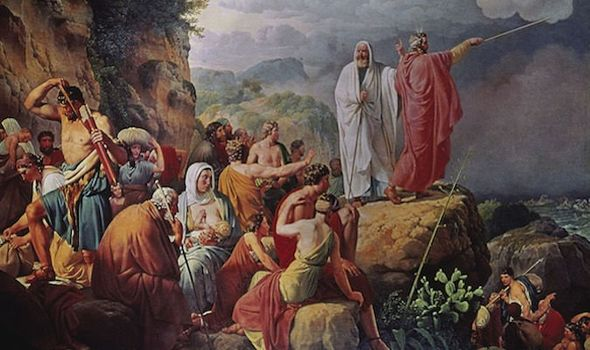

First, please acknowledge that BERT application was taken from: [this great NLP guide](https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert). If you like my notebook, please upvote also the effort of this Kaggler.

**Second, if you are interested only in the results but not technical application then just don't unhide the code and go with me through graphs and tables. If second one holds, I also discuss technical topics.** Regarding technical topics, please find short list of methods I will use:
* data enrichment - I introduce auxiliary data set with information about Biblical books
* cleaning - regular text cleaning with removal of interpuction
* stemming - I universalize the words minimizing them to just a stem
* lemmatization - grouping together the inflected forms of a word
* word clouds - plotting different parts of Bible and analysis of most frequent words
* unigrams, digrams, trigrams - the most frequent words, two-words, three-words phrases are plotted
* embedding - collective name for a set of language modeling and feature learning techniques
* BERT - I apply powerful and well-known model for this piece of text

# 1.Data preparation

I will load in the libraries which I need to use. I also need to download one package which is not in standard Kaggle suite.

In [1]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [2]:
import numpy as np
import pandas as pd
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

from collections import Counter, defaultdict
import tokenization
import string

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc

import operator

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

import gc

Next, two data sets are loaded. First, the Bible text, where each record corresponds to one verse.

In [3]:
df_path = "../input/bible/t_kjv.csv"
df = pd.read_csv(df_path)
print("The number of rows: " + format(df.shape[0]) + " The number of factors: " + format(df.shape[1]))

The number of rows: 31103 The number of factors: 5


Second, the auxiliary data set with the information about the books of the Bible:

In [4]:
df_aux_path = "../input/biblical-books-with-information/BibleBooks.csv"
df_aux = pd.read_csv(df_aux_path)
print("The number of rows: " + format(df_aux.shape[0]) + " The number of factors: " + format(df_aux.shape[1]))

The number of rows: 73 The number of factors: 7


I define the words which I don't find interesting for the analysis. They are called 'stop words', this list contains mainly words like 'up', 'to', 'with' etc, for example:

In [5]:
sw = stopwords.words('english')
sw.extend(['from', 'upon','away','even','unto'])
sw[0:5]

['i', 'me', 'my', 'myself', 'we']

Let's define the variable which will split the data set in New and Old Testament. To give some background: Bible is divided into two parts:
* after Jesus: it's New Testament with stories about Jesus (gospels) and some other about disciplies 
* before Jesus: Old Testament with the hisotry of Israel and its people

In [6]:
df['t'] = df['t'].astype('str')
df.loc[df['b'] <= 39, 'Testament'] = 'Old'
df.loc[df['b'] > 39, 'Testament'] = 'New'
df

id   b   c   v  \
0       1001001   1   1   1   
1       1001002   1   1   2   
2       1001003   1   1   3   
3       1001004   1   1   4   
4       1001005   1   1   5   
...         ...  ..  ..  ..   
31098  66022017  66  22  17   
31099  66022018  66  22  18   
31100  66022019  66  22  19   
31101  66022020  66  22  20   
31102  66022021  66  22  21   

                                                       t Testament  
0      In the beginning God created the heaven and th...       Old  
1      And the earth was without form, and void; and ...       Old  
2      And God said, Let there be light: and there wa...       Old  
3      And God saw the light, that it was good: and G...       Old  
4      And God called the light Day, and the darkness...       Old  
...                                                  ...       ...  
31098  And the Spirit and the bride say, Come. And le...       New  
31099  For I testify unto every man that heareth the ...       New  
31100  And if any man shall take away from the words ...       New  
31101  He which testifieth these things saith, Surely...       New  
31102  The grace of our Lord Jesus Christ be with you...       New  

[31103 rows x 6 columns]

Now, I enrich above data set with infromation from auxiliary data set:

In [7]:
df_enriched = df_aux.drop(['Tanakh','New Jerusalem Version'], axis=1)
df_enriched['King James Version']=df_enriched['King James Version'].replace(np.nan, 0)
df_enriched['King James Version'] = df_enriched['King James Version'].astype('int')
df_enriched

Book  King James Version  Time       Period   Location
0           Acts                  44    80    Christian       Rome
1           Amos                  30  -745    Monarchic     Israel
2         Baruch                   0  -180  Hellenistic     Israel
3   1 Chronicles                  13  -350      Persian     Israel
4   2 Chronicles                  14  -350      Persian     Israel
..           ...                 ...   ...          ...        ...
68         Titus                  56   100    Christian  Nicopolis
69         Tobit                   0  -200  Hellenistic     Israel
70        Wisdom                   0   -50    Maccabean     Israel
71     Zechariah                  38  -500      Persian     Israel
72     Zephaniah                  36  -625    Monarchic     Israel

[73 rows x 5 columns]

The result:

In [8]:
df = df.merge(df_enriched, left_on='b', right_on='King James Version')
df

id   b   c   v  \
0       1001001   1   1   1   
1       1001002   1   1   2   
2       1001003   1   1   3   
3       1001004   1   1   4   
4       1001005   1   1   5   
...         ...  ..  ..  ..   
31098  66022017  66  22  17   
31099  66022018  66  22  18   
31100  66022019  66  22  19   
31101  66022020  66  22  20   
31102  66022021  66  22  21   

                                                       t Testament  \
0      In the beginning God created the heaven and th...       Old   
1      And the earth was without form, and void; and ...       Old   
2      And God said, Let there be light: and there wa...       Old   
3      And God saw the light, that it was good: and G...       Old   
4      And God called the light Day, and the darkness...       Old   
...                                                  ...       ...   
31098  And the Spirit and the bride say, Come. And le...       New   
31099  For I testify unto every man that heareth the ...       New   
31100  And if any man shall take away from the words ...       New   
31101  He which testifieth these things saith, Surely...       New   
31102  The grace of our Lord Jesus Christ be with you...       New   

             Book  King James Version  Time     Period Location  
0         Genesis                   1  -500    Persian   Israel  
1         Genesis                   1  -500    Persian   Israel  
2         Genesis                   1  -500    Persian   Israel  
3         Genesis                   1  -500    Persian   Israel  
4         Genesis                   1  -500    Persian   Israel  
...           ...                 ...   ...        ...      ...  
31098  Revelation                  66    95  Christian   Patmos  
31099  Revelation                  66    95  Christian   Patmos  
31100  Revelation                  66    95  Christian   Patmos  
31101  Revelation                  66    95  Christian   Patmos  
31102  Revelation                  66    95  Christian   Patmos  

[31103 rows x 11 columns]

Next, I define some functions:

In [9]:
ps = PorterStemmer()

def lower_column_t(data):
    values = data['t']
    values = values.lower()
    data['t'] = values
    return data

def clean_interpunction(data):
    values = data['t']
    values = values.replace('.','')
    values = values.replace(';','')
    values = values.replace(':','')
    values = values.replace(',','')
    values = values.replace("'","")
    values = values.replace('"','')
    data['t'] = values
    return data

def stem(a):
    p = nltk.PorterStemmer()
    b = []
    for line in a:

        split_line = line.split(' ')
        length=len(split_line)
        new_line = []

        for word in range(length):
            if word == 0:
                new_line.append(str(p.stem(split_line[word])))
            else:
                new_line[0] = new_line[0] + ' ' + (str(p.stem(split_line[word])))

        b.append(new_line[0])

    return b

def lem(a):
    p = nltk.WordNetLemmatizer()
    b = []
    for line in a:

        split_line = line.split(' ')
        length=len(split_line)
        new_line = []

        for word in range(length):
            if word == 0:
                new_line.append(str(p.lemmatize(split_line[word], pos="v")))
            else:
                new_line[0] = new_line[0] + ' ' + (str(p.lemmatize(split_line[word], pos="v")))

        b.append(new_line[0])

    return b

def tokenize(a):  
    b = []
    for line in a:
        b.append(word_tokenize(line))
                 
    return b

def flatten(a):
    b = []
    for line in a:
        b = ' '.join(line)
    
    return b

def count_words(a):
    b=0
    for line in a:
        b = b + sum([i.strip(string.punctuation).isalpha() for i in line.split()])
        
    return b

def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in sw]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

Below the functions are applied. Following algorithms are applied:
* lowering the case for the text
* interpunction cleaning
* lemmatization
* stemming
* stemming of lemmatised results

In [10]:
df = df.apply(lower_column_t, axis=1)
df = df.apply(clean_interpunction, axis=1)
df['t_lem']=lem(df.t)
df['t_stem']=stem(df.t)
df['t_stem_lem']=lem(df.t_stem)
df['NoWords'] = df['t'].str.split().str.len()
#df=df.set_index('id')
df

id   b   c   v  \
0       1001001   1   1   1   
1       1001002   1   1   2   
2       1001003   1   1   3   
3       1001004   1   1   4   
4       1001005   1   1   5   
...         ...  ..  ..  ..   
31098  66022017  66  22  17   
31099  66022018  66  22  18   
31100  66022019  66  22  19   
31101  66022020  66  22  20   
31102  66022021  66  22  21   

                                                       t Testament  \
0      in the beginning god created the heaven and th...       Old   
1      and the earth was without form and void and da...       Old   
2      and god said let there be light and there was ...       Old   
3      and god saw the light that it was good and god...       Old   
4      and god called the light day and the darkness ...       Old   
...                                                  ...       ...   
31098  and the spirit and the bride say come and let ...       New   
31099  for i testify unto every man that heareth the ...       New   
31100  and if any man shall take away from the words ...       New   
31101  he which testifieth these things saith surely ...       New   
31102  the grace of our lord jesus christ be with you...       New   

             Book  King James Version  Time     Period Location  \
0         Genesis                   1  -500    Persian   Israel   
1         Genesis                   1  -500    Persian   Israel   
2         Genesis                   1  -500    Persian   Israel   
3         Genesis                   1  -500    Persian   Israel   
4         Genesis                   1  -500    Persian   Israel   
...           ...                 ...   ...        ...      ...   
31098  Revelation                  66    95  Christian   Patmos   
31099  Revelation                  66    95  Christian   Patmos   
31100  Revelation                  66    95  Christian   Patmos   
31101  Revelation                  66    95  Christian   Patmos   
31102  Revelation                  66    95  Christian   Patmos   

                                                   t_lem  \
0       in the begin god create the heaven and the earth   
1      and the earth be without form and void and dar...   
2      and god say let there be light and there be light   
3      and god saw the light that it be good and god ...   
4      and god call the light day and the darkness he...   
...                                                  ...   
31098  and the spirit and the bride say come and let ...   
31099  for i testify unto every man that heareth the ...   
31100  and if any man shall take away from the word o...   
31101  he which testifieth these things saith surely ...   
31102  the grace of our lord jesus christ be with you...   

                                                  t_stem  \
0        in the begin god creat the heaven and the earth   
1      and the earth wa without form and void and dar...   
2      and god said let there be light and there wa l...   
3      and god saw the light that it wa good and god ...   
4      and god call the light day and the dark he cal...   
...                                                  ...   
31098  and the spirit and the bride say come and let ...   
31099  for i testifi unto everi man that heareth the ...   
31100  and if ani man shall take away from the word o...   
31101  he which testifieth these thing saith sure i c...   
31102  the grace of our lord jesu christ be with you ...   

                                              t_stem_lem  NoWords  
0        in the begin god creat the heaven and the earth       10  
1      and the earth wa without form and void and dar...       29  
2      and god say let there be light and there wa light       11  
3      and god saw the light that it wa good and god ...       17  
4      and god call the light day and the dark he cal...       22  
...                                                  ...      ...  
31098  and the spirit and the bride say come and let ...       33  
31099  f

Ok, this enriched data is ready to go!

# 2.Data analysis

With this given data set, I have the comfort to apply complete analysis. First, I am starting with interesting topic: how the verse length evolves along the Bible's books. Why this information can be useful? We can more less estimate when the given books were written but it's harder to understand what was the given background and the lcoation of the book. The length of the verse gives us a lot of knowledge about the underlying culture and background behind it. 

**2.1.One way-graphs**

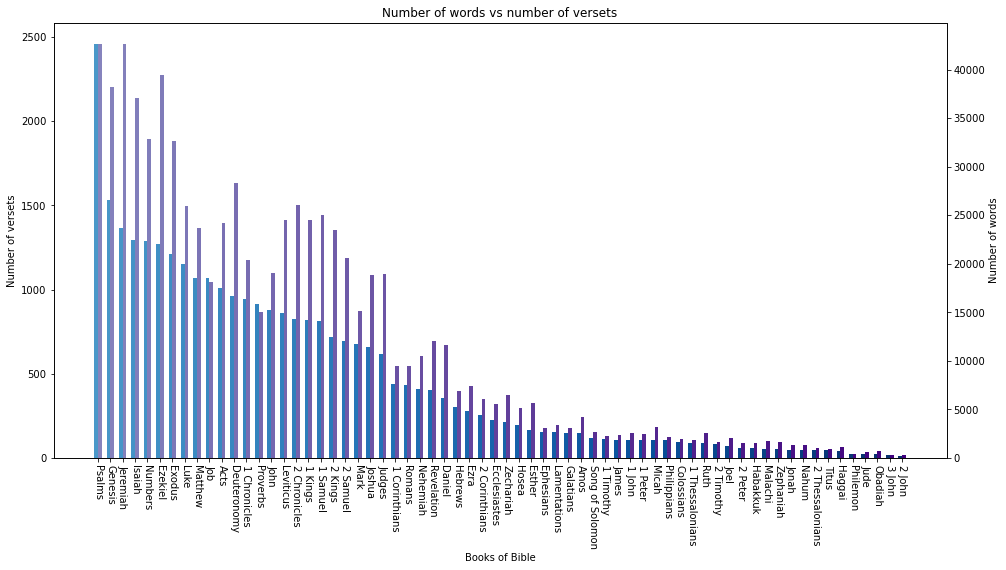

In [11]:
color_1 = plt.cm.Blues(np.linspace(0.6, 1, 66))
color_2 = plt.cm.Purples(np.linspace(0.6, 1, 66))

words_versets = df.groupby('Book').agg({'b':'count','NoWords':'sum'}).sort_values(by='b',ascending=False)
data1 = words_versets['b']
data2 = words_versets['NoWords']

plt.figure(figsize=(16,8))
x = np.arange(66)
ax1 = plt.subplot(1,1,1)
w = 0.3

color = color_1
plt.title('Number of words vs number of versets')
plt.xticks(x + w /2, data1.index, rotation=-90)
ax1.set_xlabel('Books of Bible')
ax1.set_ylabel('Number of versets')
ax1.bar(x,data1.values,color=color_1,width=w,align='center')

ax2 = ax1.twinx()

color = color_2
ax2.set_ylabel('Number of words')
ax2.bar(x + w,data2, color=color_2,width=w,align='center')

plt.show()

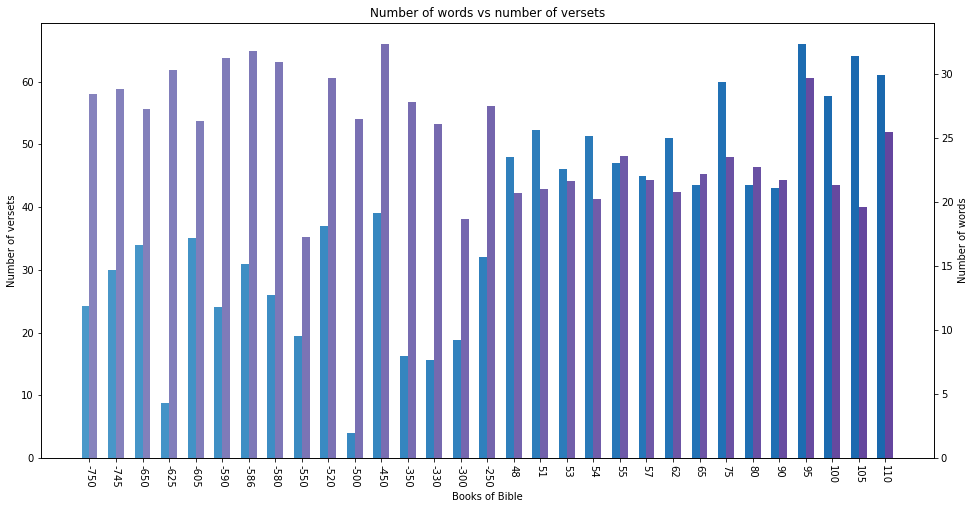

In [12]:
color_1 = plt.cm.Blues(np.linspace(0.6, 1, 66))
color_2 = plt.cm.Purples(np.linspace(0.6, 1, 66))

words_versets_ = df.groupby('Time').agg({'b':'mean','NoWords':'mean','Time':'mean'})
data1 = words_versets_['b']
data2 = words_versets_['NoWords']

plt.figure(figsize=(16,8))
x = np.arange(31)
ax1 = plt.subplot(1,1,1)
w = 0.3

color = color_1
plt.title('Number of words vs number of versets')
plt.xticks(x + w /2, data1.index, rotation=-90)
ax1.set_xlabel('Books of Bible')
ax1.set_ylabel('Number of versets')
ax1.bar(x,data1.values,color=color_1,width=w,align='center')

ax2 = ax1.twinx()

color = color_2
ax2.set_ylabel('Number of words')
ax2.bar(x + w,data2, color=color_2,width=w,align='center')

plt.show()

Fascinating to observe tthe difference between BC Bible and AD Bible. It's important to know that New Testament was written in so-called 'Koine Greek', the number of words in each verse is much higher than in Hebrew or Aramaic. And to fullfil our correlation huner, Spearman presents his best:

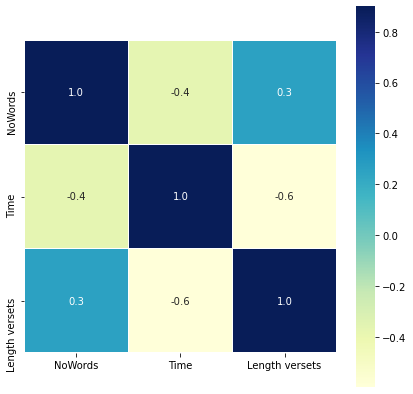

In [13]:
words_versets['Length versets'] = round(words_versets['NoWords']/words_versets['b'],0)
words_versets = words_versets.sort_values(by='Length versets',ascending=False)
df_enriched_to_merge = df_enriched.set_index('Book')
words_versets = words_versets.merge(df_enriched_to_merge, left_on='Book', right_on='Book')

SpearmanCorr = words_versets[['NoWords','Time','Length versets']].corr(method="spearman")
plt.figure(figsize=(7,7))
sns.heatmap(SpearmanCorr, vmax=.9, square=True, annot=True, linewidths=.3, cmap="YlGnBu", fmt='.1f')

**2.2.Word clouds**

Next, I look at 4 word clouds. Word cloud is the set of the most frequently appearing words in the form of cloud. I look how my text has changed by application of different methods mentined before:
* plain text
* lemmatization
* stemming
* stemming of lemmatised results

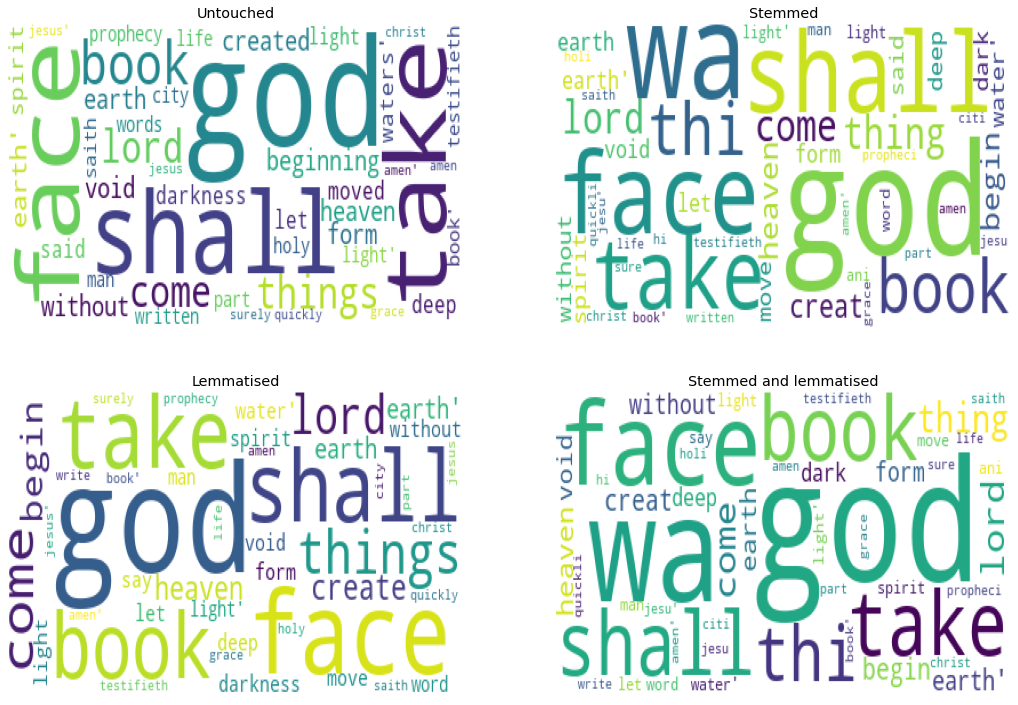

In [14]:
mpl.rcParams['figure.figsize']=(10,10)    
mpl.rcParams['font.size']=12                        
mpl.rcParams['figure.subplot.bottom']=.1 

wordcloud_t = WordCloud(background_color='white',stopwords=sw).generate(str(df['t'].values))
wordcloud_t_stem = WordCloud(background_color='white',stopwords=sw).generate(str(df['t_stem'].values))
wordcloud_t_lem = WordCloud(background_color='white',stopwords=sw).generate(str(df['t_lem'].values))
wordcloud_t_stem_lem = WordCloud(background_color='white',stopwords=sw).generate(str(df['t_stem_lem'].values))

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
ax0, ax1, ax2, ax3= ax.flatten()

ax0.imshow(wordcloud_t, aspect="auto")
ax0.title.set_text('Untouched')
ax0.axis('off')

ax1.imshow(wordcloud_t_stem, aspect="auto")
ax1.title.set_text('Stemmed')
ax1.axis('off')

ax2.imshow(wordcloud_t_lem, aspect="auto")
ax2.title.set_text('Lemmatised')
ax2.axis('off')

ax3.imshow(wordcloud_t_stem_lem, aspect="auto")
ax3.title.set_text('Stemmed and lemmatised')
ax3.axis('off')

plt.show()

Let's compare what words were the most frequent in Old & New Testaments:

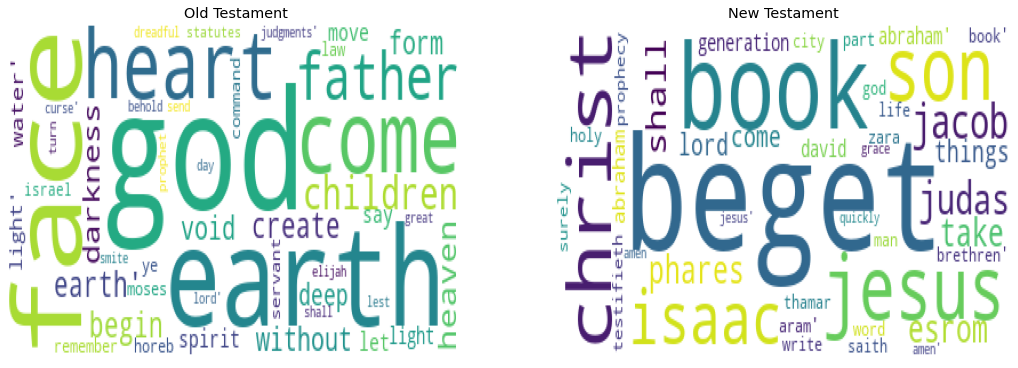

In [15]:
mpl.rcParams['figure.figsize']=(10,10)    
mpl.rcParams['font.size']=12                        
mpl.rcParams['figure.subplot.bottom']=.1 

OldTestament = df[df.b < 40]
NewTestmanet = df[df.b >= 40]

wordcloud_Old = WordCloud(background_color='white',stopwords=sw).generate(str(OldTestament.t_lem.values))
wordcloud_New = WordCloud(background_color='white',stopwords=sw).generate(str(NewTestmanet.t_lem.values))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
ax0, ax1 = ax.flatten()

ax0.imshow(wordcloud_Old, aspect="auto")
ax0.title.set_text('Old Testament')
ax0.axis('off')

ax1.imshow(wordcloud_New, aspect="auto")
ax1.title.set_text('New Testament')
ax1.axis('off')

plt.show()

Some interesting patterns between Testaments:
* 'god' got much smaller
* 'jesus' is big in New Testament, together with 'Chirst'. First word is used mostly in Gospels, second one in 'Letters of Apostoles'
* word 'face' and 'earth' are often used in Old Testament, this comes from Persian circle of culture
* New Testament is full of names, it is more descriptive, it gives infromation about certain stories with actual characters. For example: 'jacob' (disciple) or thamar (woman close to Jesus)
* 'void' was the big word in Old Testment as contrary to 'earth'. It depicts ancient view of Israeli people on the world
* pay attention to one peculiarity: 'abraham' appears more in New Testament than in old. Why? People are reffered as 'children of abraham', so all people are the center on this Testament attention. In Old Testament this role is taken by 'moses', so only Israeli people are relevant for the history
* next 'david' appears a lot in New Testament, because Jesus origins are of interest, Jesus is often reffered as 'son of David'
* characteristic for Bible word 'amen' appears almost only exclusively in New Testament. This id due to Koine Greek language
* the center of Old Testament topics are 'judgments','servant','law','statutes','curse'. This highly evolves to 'man','life','generation','grace'. These tags cover how the message of the books evolves along the centuries

If you observe another interesting trends, please share them at the end of the notebook.

**2.3.Frequency plotting**

Next, I analyse the frequency of occurence for different words in the given list:

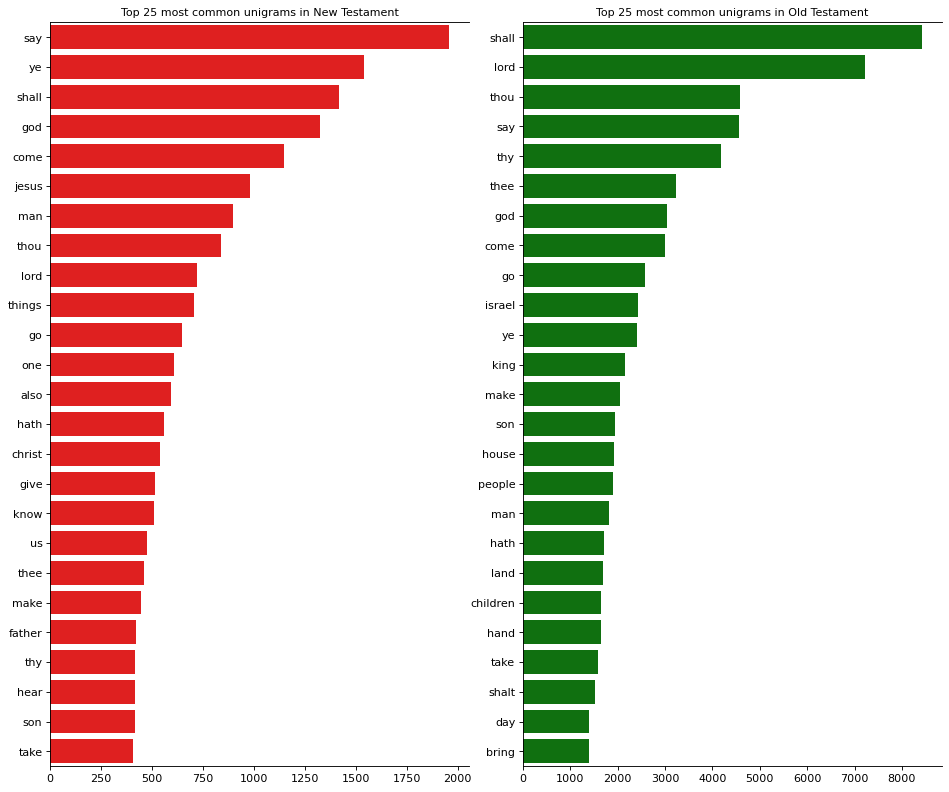

In [16]:
# Unigrams
NT_unigrams = defaultdict(int) #New Testament
OT_unigrams = defaultdict(int) #Old Testament

for line in NewTestmanet['t_lem']:
    for word in generate_ngrams(line):
        NT_unigrams[word] += 1
        
for line in OldTestament['t_lem']:
    for word in generate_ngrams(line):
        OT_unigrams[word] += 1
        
df_NT_unigrams = pd.DataFrame(sorted(NT_unigrams.items(), key=lambda x: x[1])[::-1])
df_OT_unigrams = pd.DataFrame(sorted(OT_unigrams.items(), key=lambda x: x[1])[::-1])

fig, axes = plt.subplots(ncols=2, figsize=(12, 10), dpi=80)
plt.tight_layout()

N = 25

sns.barplot(y=df_NT_unigrams[0].values[:N], x=df_NT_unigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_OT_unigrams[0].values[:N], x=df_OT_unigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=10)
    axes[i].tick_params(axis='y', labelsize=10)
    
axes[0].set_title(f'Top {N} most common unigrams in New Testament', fontsize=10)
axes[1].set_title(f'Top {N} most common unigrams in Old Testament', fontsize=10)

plt.show()

In [17]:
The frequency of bigrams, so phrases containing two words:

SyntaxError: invalid syntax (<ipython-input-17-051a6f4b6ed3>, line 1)

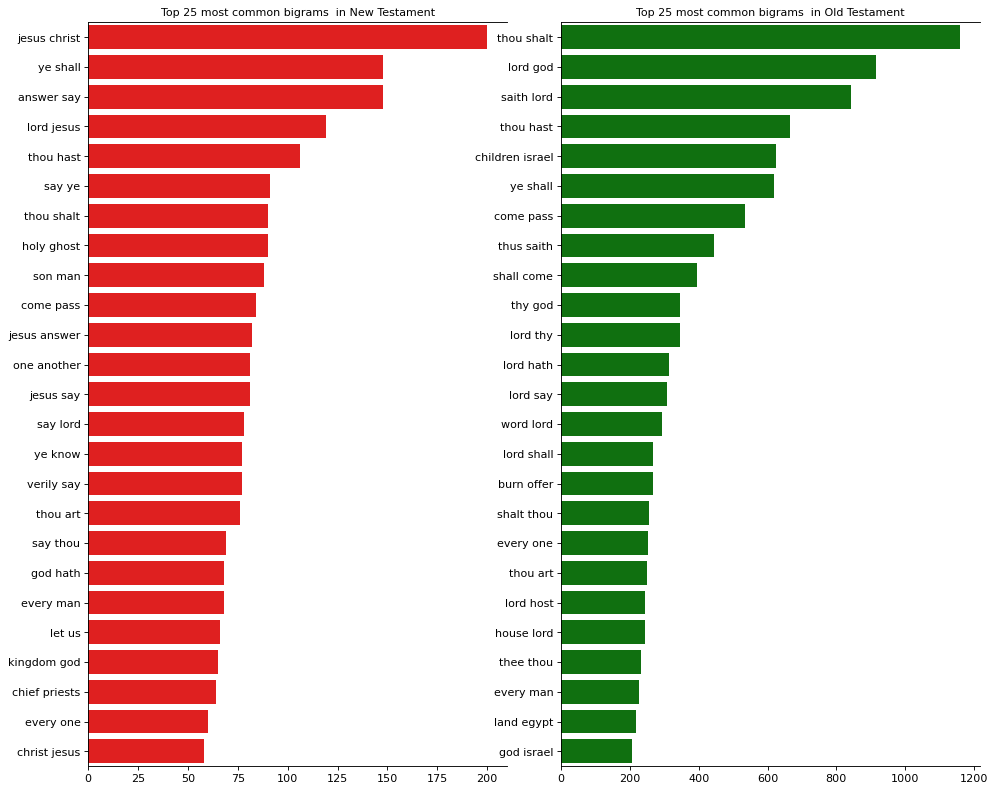

In [18]:
# Bigrams
NT_bigrams = defaultdict(int)
OT_bigrams = defaultdict(int)

for line in NewTestmanet['t_lem']:
    for word in generate_ngrams(line, n_gram=2):
        NT_bigrams[word] += 1
        
for line in OldTestament['t_lem']:
    for word in generate_ngrams(line, n_gram=2):
        OT_bigrams[word] += 1
        
df_NT_bigrams = pd.DataFrame(sorted(NT_bigrams.items(), key=lambda x: x[1])[::-1])
df_OT_bigrams = pd.DataFrame(sorted(OT_bigrams.items(), key=lambda x: x[1])[::-1])

fig, axes = plt.subplots(ncols=2, figsize=(12, 10), dpi=80)
plt.tight_layout()

N = 25

sns.barplot(y=df_NT_bigrams[0].values[:N], x=df_NT_bigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_OT_bigrams[0].values[:N], x=df_OT_bigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=10)
    axes[i].tick_params(axis='y', labelsize=10)
    
axes[0].set_title(f'Top {N} most common bigrams  in New Testament', fontsize=10)
axes[1].set_title(f'Top {N} most common bigrams  in Old Testament', fontsize=10)

plt.show()

And the frequencies of trigrams:

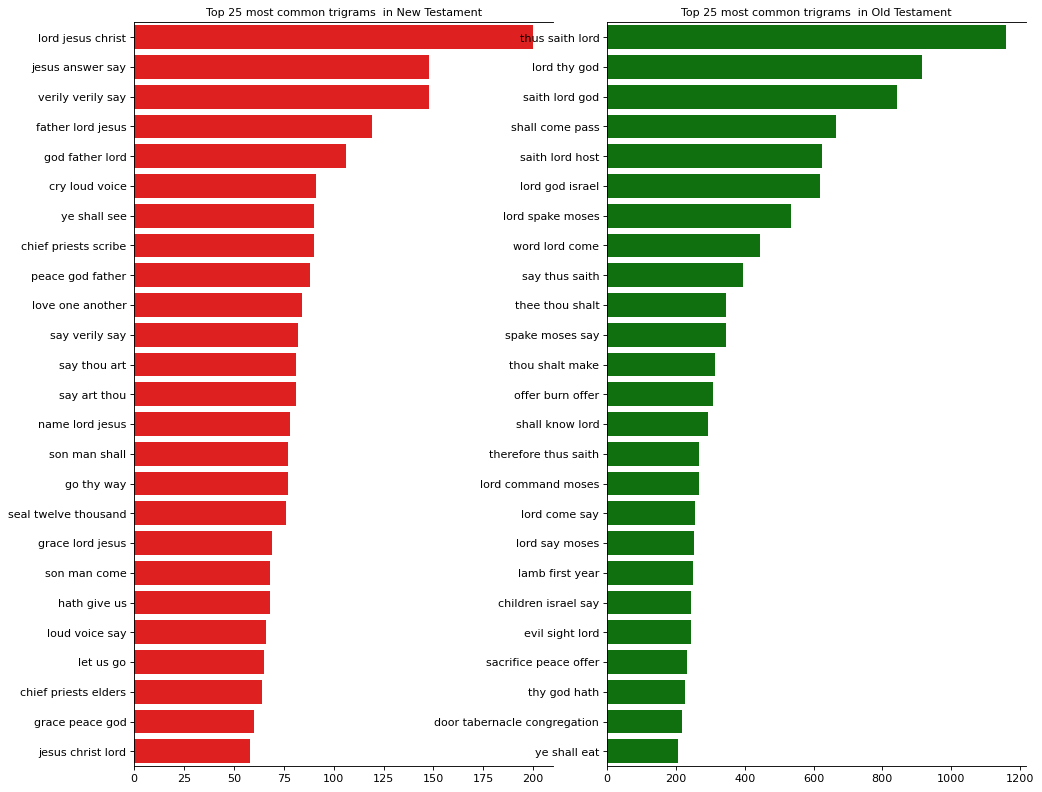

In [19]:
# Trigrams
NT_trigrams = defaultdict(int)
OT_trigrams = defaultdict(int)

for line in NewTestmanet['t_lem']:
    for word in generate_ngrams(line, n_gram=3):
        NT_trigrams[word] += 1
        
for line in OldTestament['t_lem']:
    for word in generate_ngrams(line, n_gram=3):
        OT_trigrams[word] += 1
        
df_NT_trigrams = pd.DataFrame(sorted(NT_trigrams.items(), key=lambda x: x[1])[::-1])
df_OT_trigrams = pd.DataFrame(sorted(OT_trigrams.items(), key=lambda x: x[1])[::-1])

fig, axes = plt.subplots(ncols=2, figsize=(12, 10), dpi=80)
plt.tight_layout()

N = 25

sns.barplot(y=df_NT_trigrams[0].values[:N], x=df_NT_bigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_OT_trigrams[0].values[:N], x=df_OT_bigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=10)
    axes[i].tick_params(axis='y', labelsize=10)
    
axes[0].set_title(f'Top {N} most common trigrams  in New Testament', fontsize=10)
axes[1].set_title(f'Top {N} most common trigrams  in Old Testament', fontsize=10)

plt.show()

**2.4.Clustering and SVD**

I use vectorizer and singular value decomposition to create text clusters and merge them together with the data:

In [20]:
vectorizer = TfidfVectorizer(max_df = 0.5, max_features = 1000)
X = vectorizer.fit_transform(df.t_lem)

svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
X = svd.fit_transform(X)

cluster_data = pd.DataFrame({'Comp1': X[:,0], 'Comp2': X[:,1], 'Testament': df.Testament, 'Book': df.Book, 'Period': df.Period, 'Location': df.Location, 'Time': df.Time})
cluster_data.head()

Comp1     Comp2 Testament     Book   Period Location  Time
0  0.116032  0.002109       Old  Genesis  Persian   Israel  -500
1  0.071414  0.003606       Old  Genesis  Persian   Israel  -500
2  0.102630  0.034651       Old  Genesis  Persian   Israel  -500
3  0.126188  0.007568       Old  Genesis  Persian   Israel  -500
4  0.108058 -0.030530       Old  Genesis  Persian   Israel  -500

I observe how these clusters look by 'Testament' and by historical 'Period':

Text(0.5, 1.0, 'By Period')

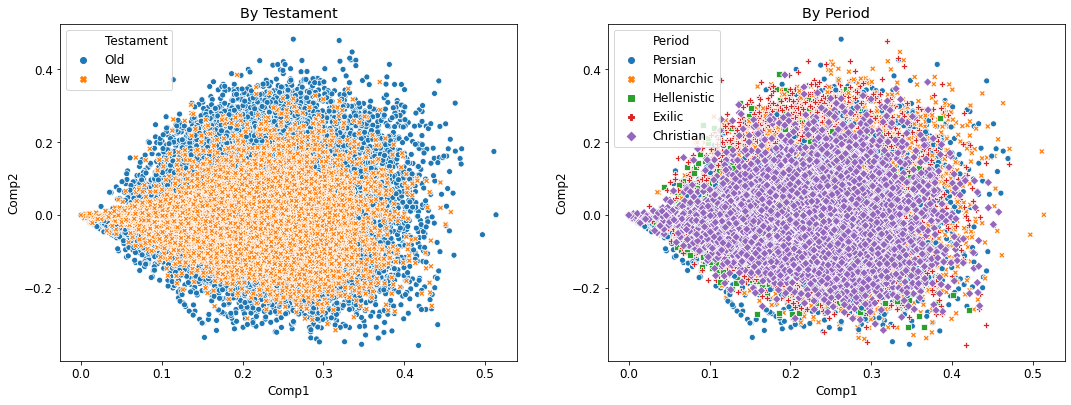

In [21]:
f, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.scatterplot('Comp1', 'Comp2', data=cluster_data, hue='Testament', ax=axes[0], style="Testament").set_title('By Testament')
sns.scatterplot('Comp1', 'Comp2', data=cluster_data, hue='Period', ax=axes[1], style="Period").set_title('By Period')

For Testaments, New one has much less extreme values and is mainly centered around the middle. Namely, a lot of text structures, which were present in Old one, are not present in New one.

Furtmermore, I can look at this cluster also by book, but the results are confusing:

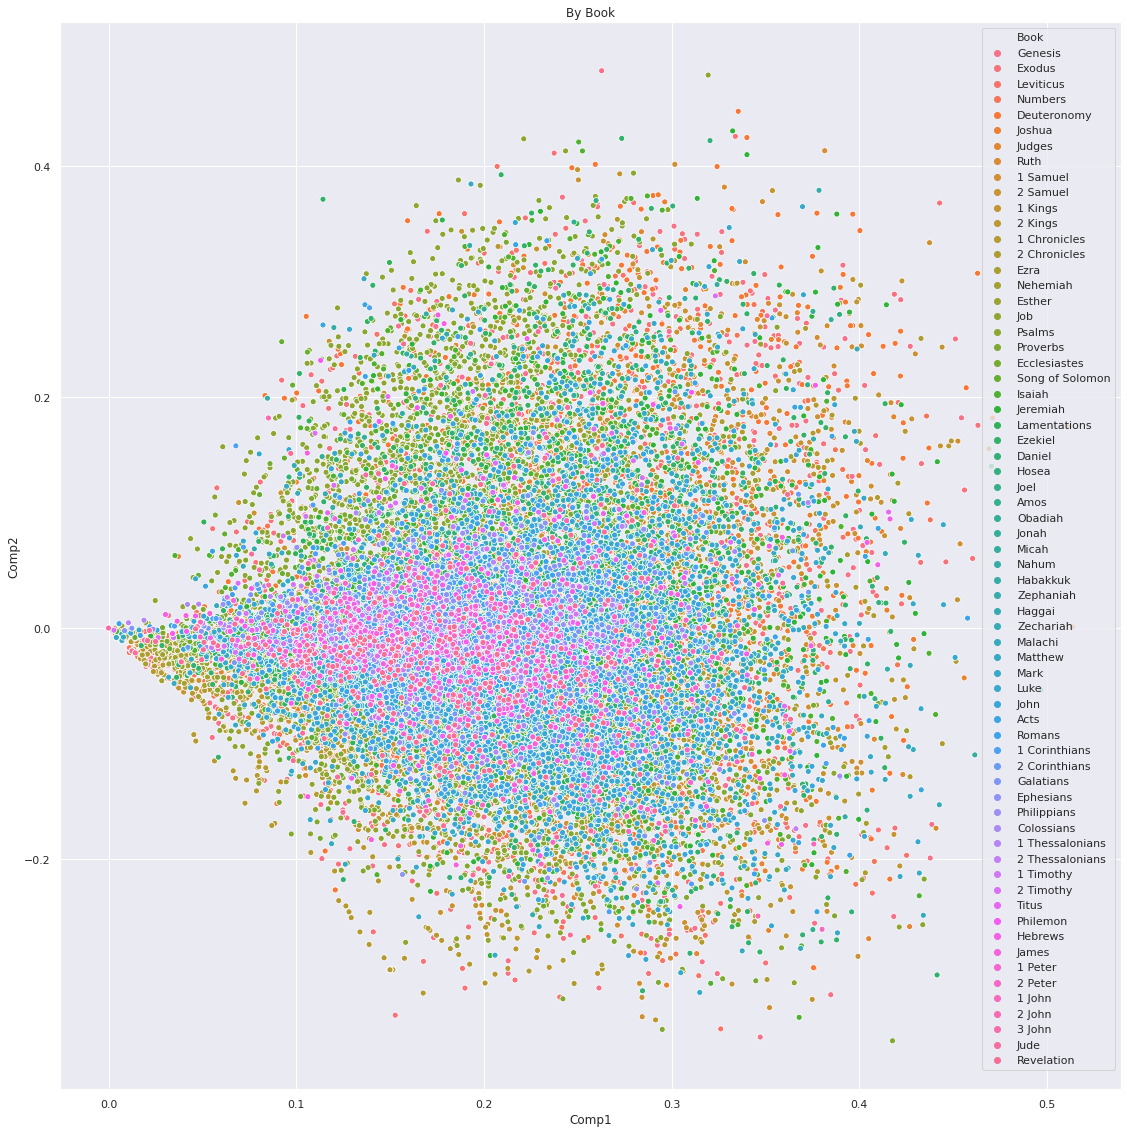

In [22]:
sns.set(rc={'figure.figsize':(19, 19)})
sns.scatterplot('Comp1', 'Comp2', data=cluster_data, hue='Book').set_title('By Book')
plt.show()

# 4.Embedding

I will analyse the vocabulary present in the Bible and check how much can be covered by our external dictionaries. First, I label 'New Testament' as '1' and 'Old' one as '0'.

In [23]:
Target = df['Testament']
df['Testament relabeled'] = df['Testament']
df['Testament relabeled'] = df['Testament relabeled'].replace("New",1)
df['Testament relabeled'] = df['Testament relabeled'].replace("Old",0)
df_train,df_test,y_train,y_test = train_test_split(df,Target,test_size=0.2,random_state=0)

Some of the functions useful for the analysis.

In [24]:
def build_vocab(X):    
    tweets = X.apply(lambda s: s.split()).values      
    vocab = {}    
    for tweet in tweets:
        for word in tweet:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1                
    return vocab

def check_embeddings_coverage(X, embeddings):   
    vocab = build_vocab(X)       
    covered = {}
    oov = {}    
    n_covered = 0
    n_oov = 0
    
    for word in vocab:
        try:
            covered[word] = embeddings[word]
            n_covered += vocab[word]
        except:
            oov[word] = vocab[word]
            n_oov += vocab[word]
            
    vocab_coverage = len(covered) / len(vocab)
    text_coverage = (n_covered / (n_covered + n_oov))   
    sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return sorted_oov, vocab_coverage, text_coverage

I load two algorithms. GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

In [25]:
glove_embeddings = np.load('../input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl', allow_pickle=True)
fasttext_embeddings = np.load('../input/pickled-crawl300d2m-for-kernel-competitions/crawl-300d-2M.pkl', allow_pickle=True)

I apply these algorithms to Bible. Performance of these algorithms:

In [26]:
train_glove_oov, train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(df_train['t_lem'], glove_embeddings)
test_glove_oov, test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(df_test['t_lem'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_glove_vocab_coverage, train_glove_text_coverage))
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_glove_vocab_coverage, test_glove_text_coverage))

train_fasttext_oov, train_fasttext_vocab_coverage, train_fasttext_text_coverage = check_embeddings_coverage(df_train['t_lem'], fasttext_embeddings)
test_fasttext_oov, test_fasttext_vocab_coverage, test_fasttext_text_coverage = check_embeddings_coverage(df_test['t_lem'], fasttext_embeddings)
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_fasttext_vocab_coverage, train_fasttext_text_coverage))
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_fasttext_vocab_coverage, test_fasttext_text_coverage))

GloVe Embeddings cover 63.86% of vocabulary and 98.11% of text in Training Set
GloVe Embeddings cover 74.13% of vocabulary and 98.13% of text in Test Set
FastText Embeddings cover 62.67% of vocabulary and 98.02% of text in Training Set
FastText Embeddings cover 73.17% of vocabulary and 98.05% of text in Test Set


Not bad, they cover approximately 98% of the text already. Next, I delete some files to make space.

In [27]:
del glove_embeddings, fasttext_embeddings, train_glove_oov, test_glove_oov, train_fasttext_oov, test_fasttext_oov
gc.collect()

49007

# 5.Estimation

This is the most interesting part of this notebook. I will apply the algorithm which will tell you whther given verse belongs to Old or New Testament. For example, I will give him the 20 words verse from Gospel and the algorithm will tell me what is the probability that it is the part of the given Testament. I use the methods from the notebook mentioned at the beginning of this file. 

Further, three blocks can be seen. In the first cross valdiation is defined. In second BERT himself and third one contains class defined set of function for this text analysis. The most important question is: what is BERT? There are couple of answers:
* [towardsdatascience](https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03)
* [medium](https://medium.com/huggingface/multi-label-text-classification-using-bert-the-mighty-transformer-69714fa3fb3d)
* and of course: [wiki](https://en.wikipedia.org/wiki/BERT_(language_model))

In [28]:
K = 2
skf = StratifiedKFold(n_splits=K, random_state=123, shuffle=True)

class ClassificationReport(Callback):
    
    def __init__(self, train_data=(), validation_data=()):
        super(Callback, self).__init__()
        
        self.X_train, self.y_train = train_data
        self.train_precision_scores = []
        self.train_recall_scores = []
        self.train_f1_scores = []
        
        self.X_val, self.y_val = validation_data
        self.val_precision_scores = []
        self.val_recall_scores = []
        self.val_f1_scores = [] 
               
    def on_epoch_end(self, epoch, logs={}):
        train_predictions = np.round(self.model.predict(self.X_train, verbose=0))        
        train_precision = precision_score(self.y_train, train_predictions, average='macro')
        train_recall = recall_score(self.y_train, train_predictions, average='macro')
        train_f1 = f1_score(self.y_train, train_predictions, average='macro')
        self.train_precision_scores.append(train_precision)        
        self.train_recall_scores.append(train_recall)
        self.train_f1_scores.append(train_f1)
        
        val_predictions = np.round(self.model.predict(self.X_val, verbose=0))
        val_precision = precision_score(self.y_val, val_predictions, average='macro')
        val_recall = recall_score(self.y_val, val_predictions, average='macro')
        val_f1 = f1_score(self.y_val, val_predictions, average='macro')
        self.val_precision_scores.append(val_precision)        
        self.val_recall_scores.append(val_recall)        
        self.val_f1_scores.append(val_f1)
        
        print('\nEpoch: {} - Training Precision: {:.6} - Training Recall: {:.6} - Training F1: {:.6}'.format(epoch + 1, train_precision, train_recall, train_f1))
        print('Epoch: {} - Validation Precision: {:.6} - Validation Recall: {:.6} - Validation F1: {:.6}'.format(epoch + 1, val_precision, val_recall, val_f1)) 

In [29]:
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1', trainable=True)

In [30]:
class TestamentDetector:
    
    def __init__(self, bert_layer, max_seq_length=128, lr=0.0001, epochs=15, batch_size=32):
        
        # BERT and Tokenization params
        self.bert_layer = bert_layer
        
        self.max_seq_length = max_seq_length        
        vocab_file = self.bert_layer.resolved_object.vocab_file.asset_path.numpy()
        do_lower_case = self.bert_layer.resolved_object.do_lower_case.numpy()
        self.tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)
        
        # Learning control params
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        
        self.models = []
        self.scores = {}

    def encode(self, texts):
                
        all_tokens = []
        all_masks = []
        all_segments = []

        for text in texts:
            text = self.tokenizer.tokenize(text)
            text = text[:self.max_seq_length - 2]
            input_sequence = ['[CLS]'] + text + ['[SEP]']
            pad_len = self.max_seq_length - len(input_sequence)

            tokens = self.tokenizer.convert_tokens_to_ids(input_sequence)
            tokens += [0] * pad_len
            pad_masks = [1] * len(input_sequence) + [0] * pad_len
            segment_ids = [0] * self.max_seq_length

            all_tokens.append(tokens)
            all_masks.append(pad_masks)
            all_segments.append(segment_ids)

        return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

    def build_model(self):
        
        input_word_ids = Input(shape=(self.max_seq_length,), dtype=tf.int32, name='input_word_ids')
        input_mask = Input(shape=(self.max_seq_length,), dtype=tf.int32, name='input_mask')
        segment_ids = Input(shape=(self.max_seq_length,), dtype=tf.int32, name='segment_ids')    
        
        pooled_output, sequence_output = self.bert_layer([input_word_ids, input_mask, segment_ids])   
        clf_output = sequence_output[:, 0, :]
        out = Dense(1, activation='sigmoid')(clf_output)
        
        model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
        optimizer = SGD(learning_rate=self.lr, momentum=0.8)
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        return model
    
    def train(self, X):
        
        for fold, (trn_idx, val_idx) in enumerate(skf.split(X['t_lem'], X['Book'])):
            
            print('\nFold {}\n'.format(fold))
        
            X_trn_encoded = self.encode(X.loc[trn_idx, 't_lem'].str.lower())
            y_trn = X.loc[trn_idx, 'Testament relabeled']
            X_val_encoded = self.encode(X.loc[val_idx, 't_lem'].str.lower())
            y_val = X.loc[val_idx, 'Testament relabeled']
        
            # Callbacks
            metrics = ClassificationReport(train_data=(X_trn_encoded, y_trn), validation_data=(X_val_encoded, y_val))
            
            # Model
            model = self.build_model()        
            model.fit(X_trn_encoded, y_trn, validation_data=(X_val_encoded, y_val), callbacks=[metrics], epochs=self.epochs, batch_size=self.batch_size)
            
            self.models.append(model)
            self.scores[fold] = {
                'train': {
                    'precision': metrics.train_precision_scores,
                    'recall': metrics.train_recall_scores,
                    'f1': metrics.train_f1_scores                    
                },
                'validation': {
                    'precision': metrics.val_precision_scores,
                    'recall': metrics.val_recall_scores,
                    'f1': metrics.val_f1_scores                    
                }
            }
            
    def plot_learning_curve(self):
        
        fig, axes = plt.subplots(nrows=K, ncols=2, figsize=(20, K * 6), dpi=100)
    
        for i in range(K):
            
            # Classification Report curve
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.models[i].history.history['val_accuracy'], ax=axes[i][0], label='val_accuracy')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.scores[i]['validation']['precision'], ax=axes[i][0], label='val_precision')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.scores[i]['validation']['recall'], ax=axes[i][0], label='val_recall')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.scores[i]['validation']['f1'], ax=axes[i][0], label='val_f1')        

            axes[i][0].legend() 
            axes[i][0].set_title('Fold {} Validation Classification Report'.format(i), fontsize=14)

            # Loss curve
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.models[0].history.history['loss'], ax=axes[i][1], label='train_loss')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.models[0].history.history['val_loss'], ax=axes[i][1], label='val_loss')

            axes[i][1].legend() 
            axes[i][1].set_title('Fold {} Train / Validation Loss'.format(i), fontsize=14)

            for j in range(2):
                axes[i][j].set_xlabel('Epoch', size=12)
                axes[i][j].tick_params(axis='x', labelsize=12)
                axes[i][j].tick_params(axis='y', labelsize=12)

        plt.show()
        
    def predict(self, X):
        
        X_test_encoded = self.encode(X['t_lem'].str.lower())
        y_pred = np.zeros((X_test_encoded[0].shape[0], 1))

        for model in self.models:
            y_pred += model.predict(X_test_encoded) / len(self.models)

        return y_pred

And then, the function from the class is applied. What is happening? BERT is applied with full cross validation on the basis of the given epoch input.

In [31]:
clf = TestamentDetector(bert_layer, max_seq_length=128, lr=0.0001, epochs=4, batch_size=32)

clf.train(df)


Fold 0

Epoch 1/4
486/486 [==============================] - ETA: 0s - loss: 0.5124 - accuracy: 0.7569
Epoch: 1 - Training Precision: 0.819808 - Training Recall: 0.633958 - Training F1: 0.654443
Epoch: 1 - Validation Precision: 0.820792 - Validation Recall: 0.630331 - Validation F1: 0.649727
486/486 [==============================] - 440s 904ms/step - loss: 0.5124 - accuracy: 0.7569 - val_loss: 0.4195 - val_accuracy: 0.8021
Epoch 2/4
486/486 [==============================] - ETA: 0s - loss: 0.3495 - accuracy: 0.8496
Epoch: 2 - Training Precision: 0.862366 - Training Recall: 0.80376 - Training F1: 0.826712
Epoch: 2 - Validation Precision: 0.856876 - Validation Recall: 0.794412 - Validation F1: 0.81831
486/486 [==============================] - 435s 896ms/step - loss: 0.3495 - accuracy: 0.8496 - val_loss: 0.3026 - val_accuracy: 0.8731
Epoch 3/4
486/486 [==============================] - ETA: 0s - loss: 0.2797 - accuracy: 0.8844
Epoch: 3 - Training Precision: 0.86298 - Training Recall: 

Let's plot the learning curves and our metrics along the epochs:

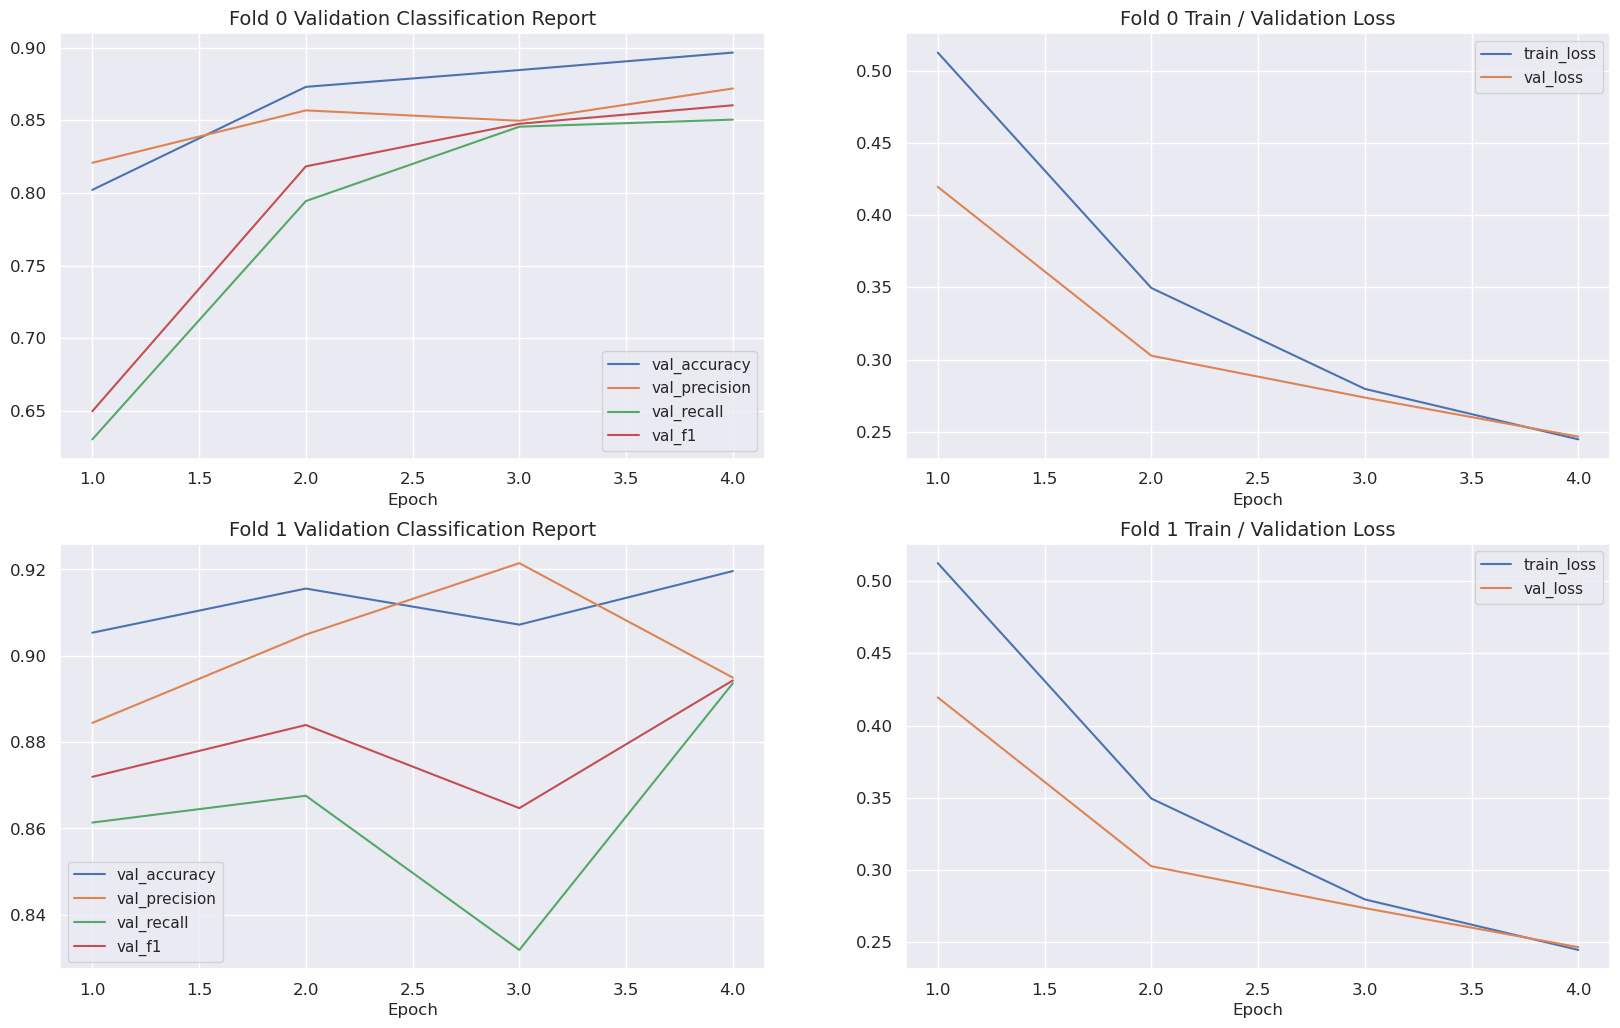

In [32]:
clf.plot_learning_curve()

I predict the reuslts, please look random 50 results. Look at 'relabeled' versus 'predictied':

In [33]:
y_pred = clf.predict(df_test)
df_test['Probabilities'] = y_pred
df_test['Testament_predicted'] = 0
df_test.loc[df_test['Probabilities'] > 0.5, 'Testament_predicted'] = 1
df_test.head(50)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

id   b    c   v  \
4103    4013028   4   13  28   
8398   10015009  10   15   9   
4433    4023017   4   23  17   
2533    2035002   2   35   2   
22406  30003011  30    3  11   
20055  24046010  24   46  10   
7421    9010003   9   10   3   
5333    5015014   5   15  14   
12565  16010016  16   10  16   
19001  24002036  24    2  36   
14174  19019006  19   19   6   
15712  19107013  19  107  13   
10388  13004003  13    4   3   
28804  47001004  47    1   4   
10948  13021014  13   21  14   
3076    3013024   3   13  24   
10324  13002018  13    2  18   
29915  56002007  56    2   7   
20881  26018032  26   18  32   
19940  24039017  24   39  17   
19866  24036024  24   36  24   
9637   12004034  12    4  34   
30036  58005006  58    5   6   
9313   11016030  11   16  30   
23102  39001013  39    1  13   
11715  14025011  14   25  11   
11900  14032025  14   32  25   
12720  17001018  17    1  18   
19504  24023020  24   23  20   
2220    2025025   2   25  25   
22747  35001016  35    1  16   
26190  43004034  43    4  34   
24131  40027002  40   27   2   
759     1027032   1   27  32   
15320  19088012  19   88  12   
27587  44019002  44   19   2   
5855    6001004   6    1   4   
22426  30005003  30    5   3   
1560    2002006   2    2   6   
18576  23045015  23   45  15   
14390  19034002  19   34   2   
20609  26008005  26    8   5   
19421  24019014  24   19  14   
20020  24044010  24   44  10   
12297  16001001  16    1   1   
3865    4007015   4    7  15   
10083  12019022  12   19  22   
30137  58010004  58   10   4   
6595    7003027   7    3  27   
6089    6010025   6   10  25   

                                                       t Testament  \
4103   nevertheless the people be strong that dwell i...       Old   
8398   and the king said unto him go in peace so he a...       Old   
4433   and when he came to him behold he stood by his...       Old   
2533   six days shall work be done but on the seventh...       Old   
22406  therefore thus saith the lord god an adversary...       Old   
20055  for this is the day of the lord god of hosts a...       Old   
7421   then shalt thou go on forward from thence and ...       Old   
5333   thou shalt furnish him liberally out of thy fl...       Old   
12565                               adonijah bigvai adin       Old   
19001  why gaddest thou about so much to change thy w...       Old   
14174  his going forth is from the end of the heaven ...       Old   
15712  then they cried unto the lord in their trouble...       Old   
10388  and these were of the father of etam jezreel a...       Old   
28804  who comforteth us in all our tribulation that ...       New   
10948  so the lord sent pestilence upon israel and th...       Old   
3076   or if there be any flesh in the skin whereof t...       Old   
10324  and caleb the son of hezron begat children of ...       Old   
29915  in all things shewing thyself a pattern of goo...       New   
20881  for i have no pleasure in the death of him tha...       Old   
19940  but i will deliver thee in that day saith the ...       Old   
19866  yet they were not afraid nor rent their garmen...       Old   
9637   and he went up and lay upon the child and put ...       Old   
30036  as he saith also in another place thou art a p...       New   
9313   and ahab the son of omri did evil in the sight...       Old   
23102  ye said also behold what a weariness is it! an...       Old   
11715  and amaziah strengthened himself and led forth...       Old   
11900  but hezekiah rendered not again according to t...       Old   
12720  likewise shall the ladies of persia and media ...       Old   
19504  the anger of the lord shall not return until h...       Old   
2220   and thou shalt make unto it a border of an han...       Old   
22747  therefore they sacrifice unto their net and bu...       Old   
26190  jesus saith unto them my meat is to do the wil...       New   
24131  and when they had bound him they led him away ...       New   


At the end the classic ROC curve:

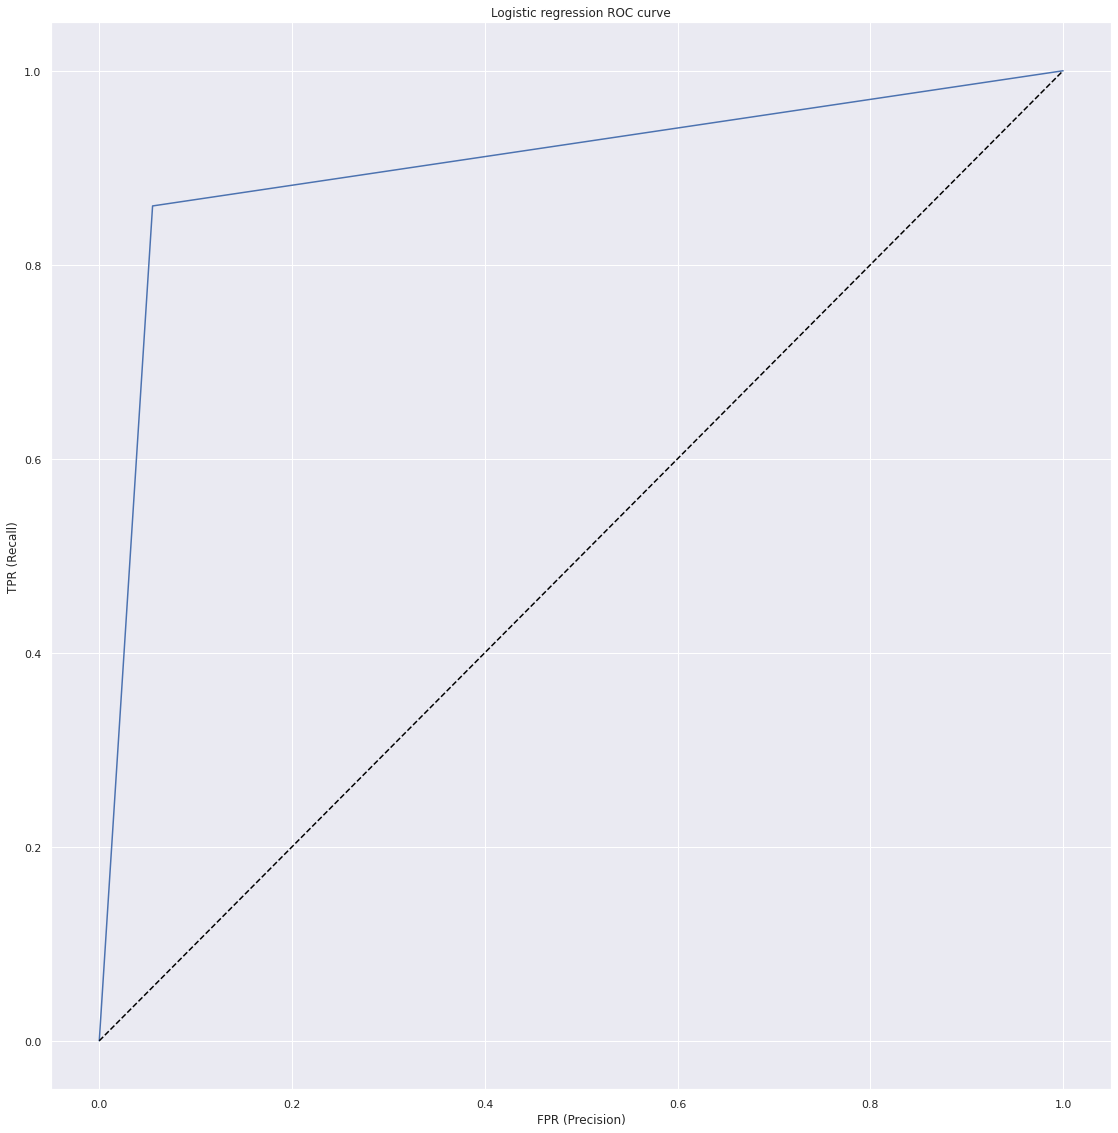

Area under curve (AUC):  0.90266


In [34]:
fpr, tpr, _ = roc_curve(df_test['Testament relabeled'], df_test.Testament_predicted)

plt.title('Logistic regression ROC curve')
plt.xlabel('FPR (Precision)')
plt.ylabel('TPR (Recall)')

plt.plot(fpr,tpr)
plt.plot((0,1), ls='dashed',color='black')
plt.show()
print ('Area under curve (AUC): ' ,format(round(auc(fpr,tpr),5)))

# 6.What's next

We see that using NLP we can understand much more than we thought about the Bible. Without using archeology, deciphering old manusricpts and traveling to excavation in Asia Minor, we can see how Bible evolved in its 1100 years history gathering the linguistic treasures of more than one milennium. This simple notebook is just a sample what we can do with the existing algortihms.

**If you like my work, please upvote this notebook.**